# Self-Driving Car Engineer Nanodegree
## Project one Lane-Line Detection

## Object for doing this project

Get familiar myself with some basic computer vision methods including:

1. Color selection in different color spaces
2. Grayscale and Gaussian blur methods available in OpenCV.
3. Canny edge detection.
4. ROI (Region of Interet) selection with mask.
5. Hough Transform method for the line generation.
6. Images fusion method.


## Import Packages

In [52]:
#importing some useful packages
import matplotlib.pyplot as plt  # For the plot method 
import matplotlib.image as mpimg # Handling with the image
import numpy as np
import cv2
%matplotlib inline 

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


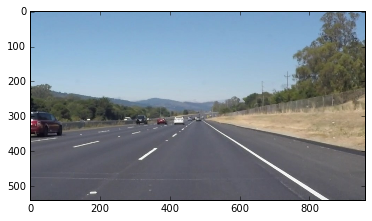

In [53]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plottin
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  

`cv2.fillPoly()` for regions selection 

`cv2.line()` to draw lines on an image given endpoints 

`cv2.addWeighted()` to coadd / overlay two images

`cv2.cvtColor()` to grayscale or change color

`cv2.imwrite()` to output images to file  

`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [54]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
def hsv(img):
    '''
    Apply the HSV color transition to better detect the yellow and white colors
    '''
    return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

def canny(img, low_threshold, high_threshold): # Here the variable image must be a grayscale image for the edge detection.
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

'''
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
'''            
def draw_lines(img,lines,color = [255,0,0],thickness = 15):
    """
    This is modified draw_line function where we can evaluate the lines' intersection and slope
    then decide whether it should belong to the left or right lane lines group, then mean the value 
    to average the line parameters.
    
    By doing so, we can eliminate some drawbacks where we wrongly detect the road side as a lane line.

    """
    # Define a list to store the information of slope and intersection of all the lines 
    # detected by Hough line function in the format of [slope,intersection]
    lines_slopes_intersections = np.zeros((len(lines),2))
    # For the image, shape[0] is the height which means the y value.
    x = img.shape[1]
    y = img.shape[0]
    
    # Store all the information of the detected lines to the lines_slope_intersection list
    for index,line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intersection = y1 - slope * x1
            lines_slopes_intersections[index] = [slope,intersection]
    
    # Find the max and min slope for all the detected lines, and note that the max slope corresponds 
    # to the right lane line reference, the minimum is the left reference
    maximum_slope_intersection = lines_slopes_intersections[lines_slopes_intersections.argmax(axis = 0)[0]]
    minimum_slope_intersection = lines_slopes_intersections[lines_slopes_intersections.argmin(axis = 0)[0]]
    
   
    left_slopes = []
    right_slopes = []
    
    left_intersections = []
    right_intersections = []
    for index, line_slope_intersection in enumerate(lines_slopes_intersections):
        if abs(line_slope_intersection[0] - maximum_slope_intersection[0]) < 0.1 and abs(line_slope_intersection[1] - maximum_slope_intersection[1]) < 0.1 * x:
            right_slopes.append(line_slope_intersection[0])
            right_intersections.append(line_slope_intersection[1])
        if abs(line_slope_intersection[0] - minimum_slope_intersection[0]) < 0.1 and abs(line_slope_intersection[1] - minimum_slope_intersection[1]) < 0.1 * x:
            left_slopes.append(line_slope_intersection[0])
            left_intersections.append(line_slope_intersection[1])
            
    # Delete some extrame slope lines considering the last video where the car hook is observed.
    
    # Caculate the averaged slope and intersections for right and left lane lines.
    right_line_slope = np.mean(right_slopes)
    right_line_intersection = np.mean(right_intersections)
    
    # print(right_line_slope)
    left_line_slope = np.mean(left_slopes)
    left_line_intersection = np.mean(left_intersections)
    # print(left_line_slope)
    new_lines = np.zeros((2,4),dtype=np.int32)
    
    # Caculate the bottom and top x coordinates 
    right_bottom_x = (y - right_line_intersection) / right_line_slope
    right_top_x = (y * .575 - right_line_intersection) / right_line_slope
    
    left_bottom_x = (y - left_line_intersection) / left_line_slope
    left_top_x = (y * 0.575 - left_line_intersection) / left_line_slope
    # print(right_bottom_x,left_bottom_x,x)
    # Store the coordinates in the list for drawing the lines
    if right_bottom_x < x:
        new_lines[0] = [right_bottom_x,y,right_top_x,y * .575]
    if left_bottom_x > 0:
        new_lines[1] = [left_bottom_x,y,left_top_x,y * .575]
    # new_lines[0][0] = [left_bottom_x,y,left_top_x,y * .575]
    # new_lines[0][1] = [right_bottom_x,y,right_top_x,y * .575]
    
    for x1,y1,x2,y2 in new_lines:
        cv2.line(img,(x1,y1),(x2,y2),color,thickness)

    
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

First, I need to test the images with the pipeline designed based on the above available function and check the perfromance.

In [55]:
import os
test_images = os.listdir("test_images/")
print(test_images)

['solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'solidWhiteCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline

This basic pipeline is created based on the available functions above, and will be tested on all the test images.

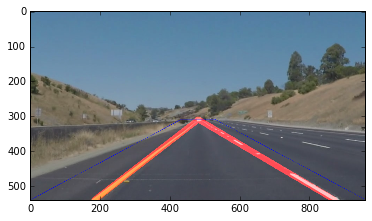

In [66]:
# The pipeline function for the lane line detection,Please remember to copy all the test 
# images in order not to change them.
'''
def lane_line_mapout(img):
        
        # Transfer it to the grayscale image
        image = np.copy(img)
    
        gray_image = grayscale(image)
    
        # Add the Gaussian blur to reduce the high frequency noise.
        blurred_gray = gaussian_blur(gray_image,5)
    
        # With the blurred_gray image, we can detect the edge with canny function
        edge_image = canny(blurred_gray,55,155) # The suggested ratio for high and low 
                                                 # threshold value is 2:1 or 3:1
        # ROI selection with the mask method.
        x = image.shape[1]
        y = image.shape[0]
        vertice = np.array([[(0,y),(x*.45,y*0.575),(x*.55,y*.575),(x,y)]],np.int32)
        masked_edge_image = region_of_interest(edge_image,vertice)
    
        # Define the parameters for the hough transform function
        rho = 2
        theta = math.pi / 180
        threshold = 80
        min_line_len = 60
        max_line_gap = 250
        
    
        red_lines_in_black_backgroud = hough_lines(masked_edge_image,rho,theta,threshold,min_line_len,max_line_gap)
    
        # Then through the weighted image for the output
        
        
        α = 0.8
        β = 1.0
        λ = 0.0
    
        output_image = weighted_img(red_lines_in_black_backgroud,image,α, β, λ)
        #cv2.imwrite("output_image/")
        cv2.polylines(output_image,[vertice],True,[0,0,255])
        return output_image

output_image = lane_line_mapout(image)
plt.imshow(output_image)
mpimg.imsave('output_image/simple_.jpg',output_image)

'''
def lane_line_mapout(img):
    """In order to select the special colors including the white and yellow which is mainly for 
     painting the lane lines in the image or video. We can use the HSV (hue saturation Value) to 
     better detect the color"""
    # Get the grayscale image for the RGB colored image
    gray_img = grayscale(img)
    # Get the hsv color space
    hsv_img = hsv(img)
    
    # Define the different color threshold for selecting the white and yellow colors
    yellow_low_threshold = np.array([15,0,0],dtype=np.int8)
    yellow_high_threshold = np.array([40,255,255],dtype=np.int8)
    white_low_threshold = np.array([0,0,150],dtype = np.int8)
    white_high_threshold = np.array([255,255,255],dtype =np.int8)
    
    # Get the binary images by selecting the area where the characteristic are suitable for the thresholds
    hsv_yellow = cv2.inRange(hsv_img,yellow_low_threshold,yellow_high_threshold)
    hsv_white = cv2.inRange(hsv_img,white_low_threshold,white_high_threshold)
    
    # The white and yellow arae selection (shown as white pixels)
    hsv_y_w = cv2.bitwise_or(hsv_yellow,hsv_white)
    # Fused with the grayscale image
    full_mask = cv2.bitwise_or(hsv_y_w,gray_img)
    
    # Manipulate the canny edge detection funtion
    edge_low_threshold = 80
    edge_high_threshold = 155
    
    edge_img = canny(full_mask,edge_low_threshold,edge_high_threshold)
    
    # ROI function to select the region of interest where we'll map out the lane lines
    x = img.shape[1]
    y = img.shape[0]
    
    vertices = np.array([[(0,y),(x*.45,y*0.575),(x*.55,y*.575),(x,y)]],dtype=np.int32)
    masked_edge_image = region_of_interest(edge_img,vertices)
    
    # Define the parameters for the hough transform function
    rho = 2
    theta = math.pi / 180
    threshold = 80
    min_line_len = 60
    max_line_gap = 150
        
    
    red_lines_in_black_backgroud = hough_lines(masked_edge_image,rho,theta,threshold,min_line_len,max_line_gap)
    
    # Then through the weighted image for the output
        
        
    α = 0.8
    β = 1.0
    λ = 0.0
    
    output_image = weighted_img(red_lines_in_black_backgroud,image,α, β, λ)
    #cv2.imwrite("output_image/")
    cv2.polylines(output_image,[vertices],True,[0,0,255])
    return output_image
output_image = lane_line_mapout(image)
plt.imshow(output_image)

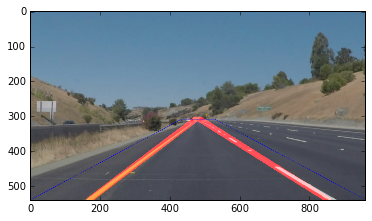

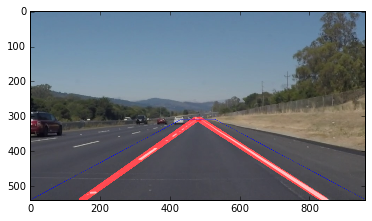

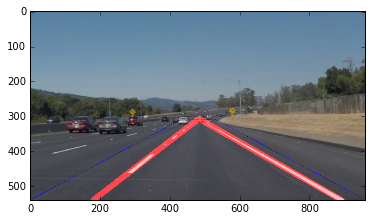

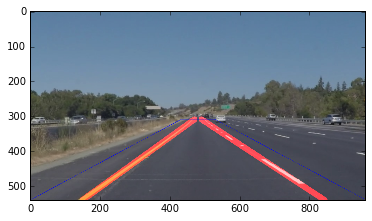

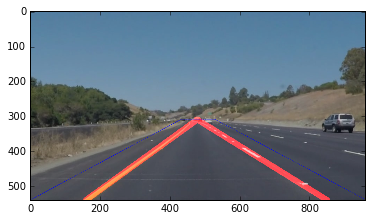

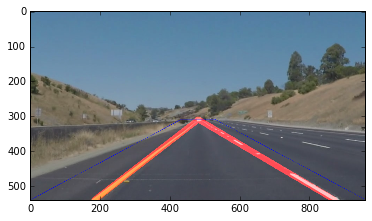

In [57]:
# Apply the pipeline for all the test images 
for i in test_images:
    
    image = mpimg.imread('test_images/' + i)
    output_image = lane_line_mapout(image)
    figure = plt.figure()
    plt.imshow(output_image)
    mpimg.imsave("output_image/"+"out_"+i,output_image)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [58]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [59]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    # you should return the final output (image where lines are drawn on lanes)
    # Get the grayscale image for the RGB colored image
    gray_img = grayscale(img)
    # Get the hsv color space
    hsv_img = hsv(img)
    
    # Define the different color threshold for selecting the white and yellow colors
    yellow_low_threshold = np.array([15,0,0],dtype=np.int8)
    yellow_high_threshold = np.array([40,255,255],dtype=np.int8)
    white_low_threshold = np.array([0,0,150],dtype = np.int8)
    white_high_threshold = np.array([255,255,255],dtype =np.int8)
    
    # Get the binary images by selecting the area where the characteristic are suitable for the thresholds
    hsv_yellow = cv2.inRange(hsv_img,yellow_low_threshold,yellow_high_threshold)
    hsv_white = cv2.inRange(hsv_img,white_low_threshold,white_high_threshold)
    
    # The white and yellow arae selection (shown as white pixels)
    hsv_y_w = cv2.bitwise_or(hsv_yellow,hsv_white)
    # Fused with the grayscale image
    full_mask = cv2.bitwise_or(hsv_y_w,gray_img)
    
    # Manipulate the canny edge detection funtion
    edge_low_threshold = 80
    edge_high_threshold = 155
    
    edge_img = canny(full_mask,edge_low_threshold,edge_high_threshold)
    
    # ROI function to select the region of interest where we'll map out the lane lines
    x = img.shape[1]
    y = img.shape[0]
    
    vertices = np.array([[(0,y),(x*.45,y*0.575),(x*.55,y*.575),(x,y)]],dtype=np.int32)
    masked_edge_image = region_of_interest(edge_img,vertices)
    
    # Define the parameters for the hough transform function
    rho = 2
    theta = math.pi / 180
    threshold = 80
    min_line_len = 60
    max_line_gap = 150
        
    
    red_lines_in_black_backgroud = hough_lines(masked_edge_image,rho,theta,threshold,min_line_len,max_line_gap)
    
    # Then through the weighted image for the output
        
        
    α = 0.8
    β = 1.0
    λ = 0.0
    
    output_image = weighted_img(red_lines_in_black_backgroud,img,α, β, λ)
    #cv2.imwrite("output_image/")
    #cv2.polylines(output_image,[vertices],True,[0,0,255])
    return output_image

Let's try the one with the solid white lane on the right first ...

In [60]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 9.4 s, sys: 268 ms, total: 9.67 s
Wall time: 8.37 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [62]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:25<00:00, 26.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 30.3 s, sys: 680 ms, total: 31 s
Wall time: 26.9 s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [64]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:20<00:00, 10.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 17.8 s, sys: 372 ms, total: 18.2 s
Wall time: 23 s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))